Cleansing & Transforming  
Summary of steps:  

-Merge Weather attributes and Bike data
-Convert datetime columns from 'object' type to 'datetime' type  
-Add new column to identify the weeknum (ie. 1 to 52)  
-Add new column to identify the month (ie. 1 to 12 - Jan to Dec)  
-Add new column to identify the hour (ie. 0 to 23)  
-Add new column to identify the weekday (ie. 0 to 7 - Mon to Sun)  



In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the Bike Data

In [2]:
df_bixi = pd.read_csv('../../Data/Raw/MTL_data/OD_2017.csv',low_memory=False)
df_stn = pd.read_csv('../../Data/Raw/MTL_data/Stations_2017.csv',low_memory=False)

# Procedures

In [3]:
# Add new column to identify the time of day (ie. AM1, AM2, PM1, PM2)  # def timeday(df):
#     result = []
#     for row in df:
#         if row <= 5:
#             #early morning 0:00 to 5:59
#             result.append('AM1')  
#         elif row <= 11:
#             #morning 6:00 to 11:59
#             result.append('AM2')
#         elif row <= 17:
#             #afternoon 12:00 to 17:59
#             result.append('PM1')
#         elif row <= 23:
#             #evening 18:00 to 11:59
#             result.append('PM2')
#         else:
#             result.append('')
#     return result

# Transform the data

In [4]:
# Convert end station code to numeric; similar to start station code, which is already numeric
# Convert duration from seconds to minutes
df_bixi['end_station_code']=pd.to_numeric(df_bixi['end_station_code'],errors='coerce',downcast='signed')
df_bixi.insert(5,'duration_min',df_bixi['duration_sec']/60)
df_bixi = df_bixi.drop('duration_sec',1)

In [5]:
#convert dates to datetime type
df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])                               

In [6]:
#check for nan
print(df_bixi.isnull().sum())

Unnamed: 0            0
start_date            0
start_station_code    0
end_date              0
end_station_code      1
duration_min          0
is_member             0
dtype: int64


In [7]:
#drop na rows
df_bixi=df_bixi.dropna() 

In [8]:
df_bixi.head()

,Unnamed: 0,start_date,start_station_code,end_date,end_station_code,duration_min,is_member
0,0,2017-04-15 00:00:00,7060,2017-04-15 00:31:00,7060.0,30.683333,1
1,1,2017-04-15 00:01:00,6173,2017-04-15 00:10:00,6173.0,9.216667,1
2,2,2017-04-15 00:01:00,6203,2017-04-15 00:04:00,6204.0,3.250000,1
3,3,2017-04-15 00:01:00,6104,2017-04-15 00:06:00,6114.0,4.750000,1
4,4,2017-04-15 00:01:00,6174,2017-04-15 00:11:00,6174.0,9.483333,1


In [9]:
df_bixi.dtypes

Unnamed: 0                     int64
start_date            datetime64[ns]
start_station_code             int64
end_date              datetime64[ns]
end_station_code             float64
duration_min                 float64
is_member                      int64
dtype: object

In [10]:
#sort by start date
df_bixi = df_bixi.sort_values(by = ['start_date'])

# Merge bixi data with weather data

In [11]:
#read Montreal weather data
df_Mtl = pd.read_csv('../../Data/Processed/Montreal.csv')

In [12]:
#merge bixi data with weather data - inner join
df_Mtl['datetime'] = pd.to_datetime(df_Mtl['datetime'])
df_all = pd.merge_asof(df_bixi, df_Mtl, left_on = 'start_date', right_on = 'datetime', direction = 'nearest')    

In [13]:
print(df_all.isnull().sum())

Unnamed: 0            0
start_date            0
start_station_code    0
end_date              0
end_station_code      0
duration_min          0
is_member             0
datetime              0
humidity              0
pressure              0
temp_celsius          0
description           0
wind_speed            0
wind_direction        0
dtype: int64


In [14]:
#determine weekday, month, hour and week number
month_name = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
week_day = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
month_label = ['Apr','May','Jun','Jul','Aug','Sep']
weekday_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

#df = df_all.start_date.dt.dayofweek.astype(str) + " - " + df_all.start_date.dt.dayofweek.map(week_day)
df = df_all.start_date.dt.dayofweek
df_all.insert(2,'weekday',df)

#df = df_all.start_date.dt.month.astype(str) + " - " + df_all.start_date.dt.month.map(month_name)
df = df_all.start_date.dt.month
df_all.insert(3,'month',df)

df = df_all.start_date.dt.hour
df_all.insert(4,'hour',df)

df = df_all.start_date.dt.weekofyear
df_all.insert(5,'num_week',df)

In [16]:
df_all.dtypes

Unnamed: 0                     int64
start_date            datetime64[ns]
weekday                        int64
month                          int64
hour                           int64
num_week                       int64
start_station_code             int64
end_date              datetime64[ns]
end_station_code             float64
duration_min                 float64
is_member                      int64
datetime              datetime64[ns]
humidity                     float64
pressure                     float64
temp_celsius                 float64
description                   object
wind_speed                   float64
wind_direction               float64
dtype: object

In [17]:
df_all = df_all.drop(df_all.columns[df_all.columns.str.contains('Unnamed',case = False)],axis = 1)
df_all.to_csv('../../Data/Processed/bixiWeather.csv',index=False)

# Data Visualization

Text(0.5,0,'Temperature (celsius)')

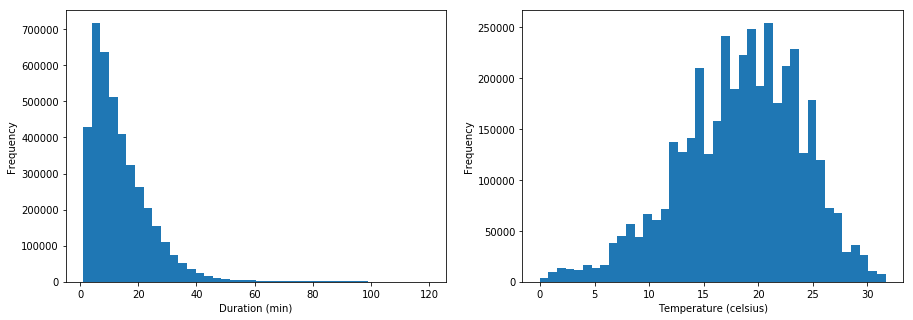

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

#Number of bixi rides by duration
df_all['duration_min'].plot.hist(bins=40)
plt.xlabel('Duration (min)')

#Number of bixi rides by temperature
plt.subplot(1,2,2)
df_all['temp_celsius'].plot.hist(bins=40)
plt.xlabel('Temperature (celsius)')


Text(0.5,0,'Destination station')

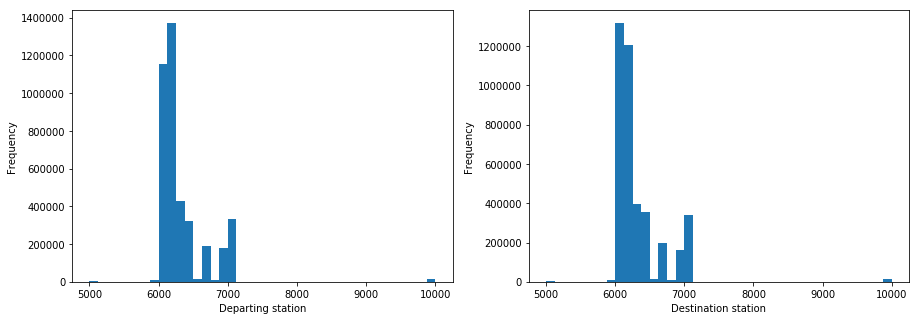

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

#Number of bixi rides by Departing Station
df_all['start_station_code'].plot.hist(bins=40)
plt.xlabel('Departing station')

#Number of bixi rides by Destination Station
plt.subplot(1,2,2)
df_all['end_station_code'].plot.hist(bins=40)
plt.xlabel('Destination station')

In [20]:
# grouping the data by multiple column
df_all.groupby(by=['is_member', 'month'])['duration_min'].count().round()

is_member  month
0          4         32451
           5        106255
           6        143449
           7        206769
           8        187826
           9        129994
1          4        163876
           5        483597
           6        604631
           7        670571
           8        671648
           9        617654
Name: duration_min, dtype: int64

# Bike Usage

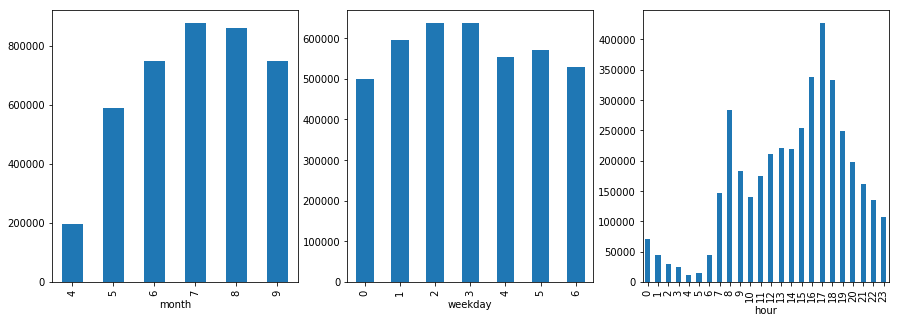

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
df_all.groupby('month').count()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,2)
df_all.groupby('weekday').count()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,3)
df_all.groupby('hour').count()['duration_min'].plot(kind='bar', color='#1f77b4')

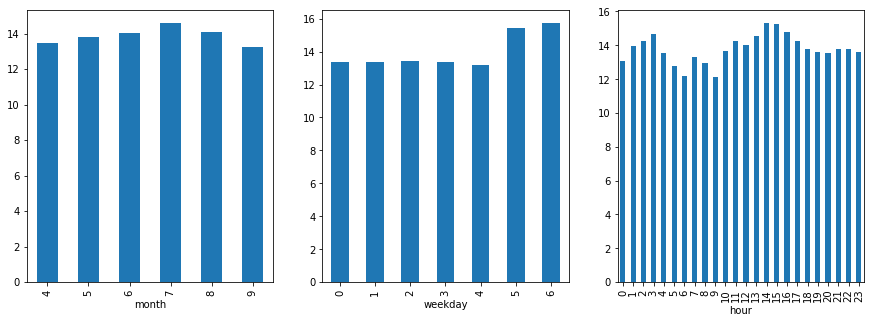

In [22]:
#Average

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
df_all.groupby('month').mean()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,2)
df_all.groupby('weekday').mean()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,3)
df_all.groupby('hour').mean()['duration_min'].plot(kind='bar', color='#1f77b4')

In [23]:
df_pivot = df_all.pivot_table(columns='hour',index='weekday', aggfunc=np.count_nonzero)['duration_min'];

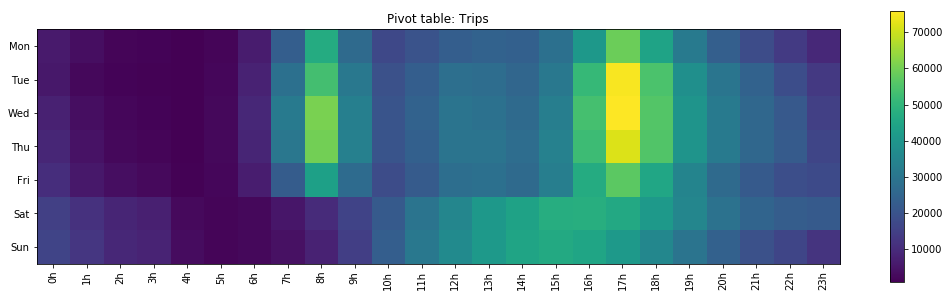

In [24]:
#most rides occur weekdays at 8am and  between 4pm to 6pm
#yellow and light green colors show higher number of rides

plt.figure(figsize=(18,5))
plt.title('Pivot table: Trips')
plt.imshow(df_pivot,interpolation='none')

hours = range(24)
hour_label = map(lambda x: str(x)+'h',hours)
weekdays = range(7)

plt.xticks(hours,hour_label,rotation=90)
plt.yticks(weekdays,weekday_label)
plt.colorbar()


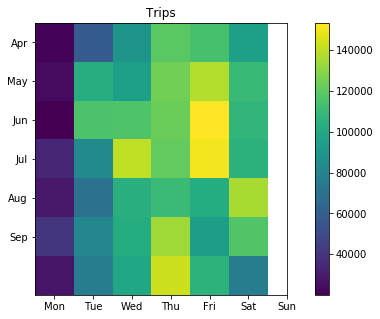

In [25]:
#Let us look of volume of rides by month and weekday
#lowest volume of rides seem to occur on Mondays

df_pivot2 = df_all.pivot_table(columns='month',index='weekday', aggfunc=np.count_nonzero)['duration_min'];

# Heatmap
plt.figure(figsize=(10,5))
plt.title('Trips')
plt.imshow(df_pivot2,interpolation='none')

months = range(6)
weekdays = range(7)

plt.xticks(weekdays,weekday_label)
plt.yticks(months,month_label)
plt.colorbar()


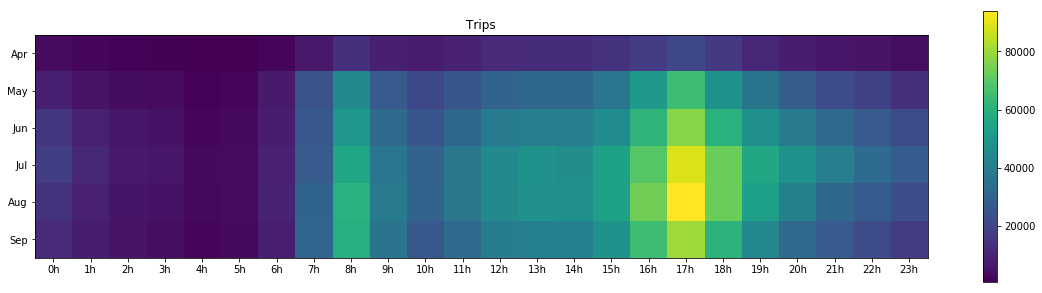

In [26]:
#Let us look of volume of rides by month and hour of the day
#higher volume of rides seem to occur between 4pm and 6pm
df_pivot3 = df_all.pivot_table(columns='hour',index='month', aggfunc=np.count_nonzero)['duration_min']

plt.figure(figsize=(20,5))
plt.title('Trips')
plt.imshow(df_pivot3,interpolation='none')

months = range(6)
hours = range(24)
hour_label = map(lambda x: str(x)+'h',hours)

plt.xticks(hours,hour_label)
plt.yticks(months,month_label)
plt.colorbar()

In [27]:
df_start = df_all.groupby('start_station_code').count()['duration_min'].to_frame();
df_top = df_start.sort_values(by = ['duration_min'], ascending=False);

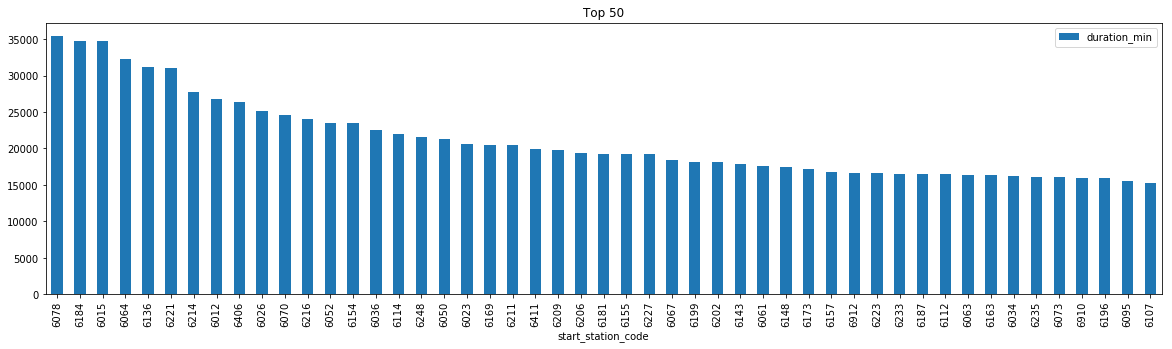

In [28]:
#Top 50 Departing stations
df_top[1:50].plot(kind='bar', color='#1f77b4', figsize=(20,5));
plt.title('Top 50');

In [31]:
#It would have been interesting to see a map representation of the top and bottom 50 departing stations

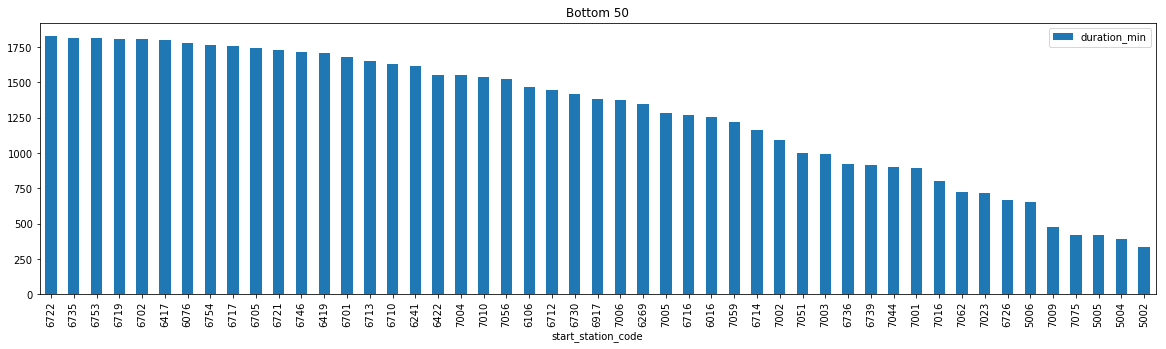

In [29]:
#Bottom 50 Departing stations
df_top[-50:-1].plot(kind='bar', color='#1f77b4', figsize=(20,5));
plt.title('Bottom 50');

Text(0,0.5,'Trips')

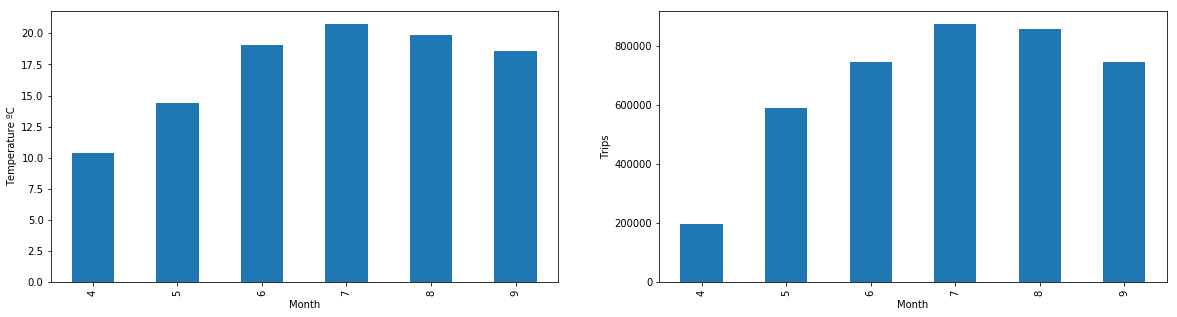

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_all.groupby('month').mean()['temp_celsius'].plot(kind='bar',color='#1f77b4')
plt.ylabel('Temperature ºC')
plt.xlabel('Month')

plt.subplot(1,2,2)
df_all.groupby('month').count()['temp_celsius'].plot(kind='bar',color='#1f77b4')
plt.xlabel('Month')
plt.ylabel('Trips')

7    877340
8    859474
6    748080
9    747648
5    589852
4    196327
Name: month, dtype: int64


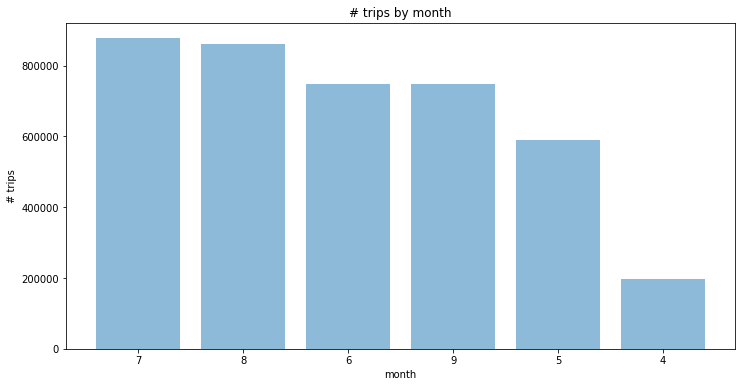

In [34]:
print(df_all['month'].value_counts())

# Bar Chart
plt.figure(figsize=(12,6))
plt.title('# trips by month')
plt.xlabel('month')
plt.ylabel('# trips')

labels = df_all['month'].value_counts().index
values = df_all['month'].value_counts().values

y_pos = range(len(labels))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.show()

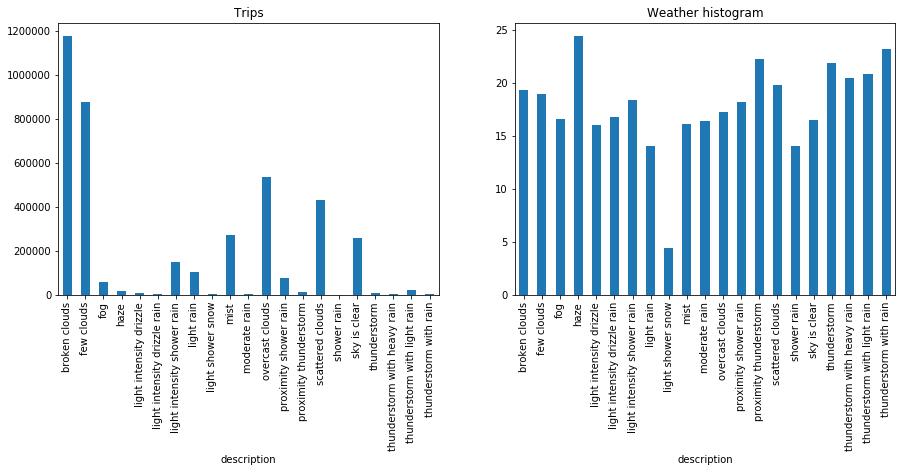

In [35]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1);
df_all.groupby('description').count()['duration_min'].plot(kind='bar',color='#1f77b4');
plt.title('Trips');

plt.subplot(1,2,2);
df_all.groupby('description').mean()['temp_celsius'].plot(kind='bar',color='#1f77b4');
plt.title("Weather histogram");

Text(0.5,1,'Weather histogram')

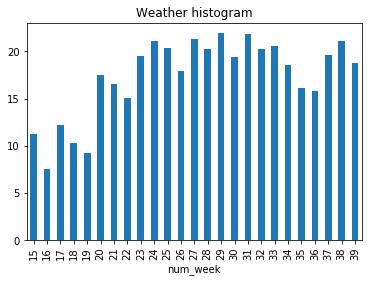

In [37]:
#plt.subplot(1,2,2)
df_all.groupby('num_week').mean()['temp_celsius'].plot(kind='bar',color='#1f77b4')
#df_all.groupby('num_week').mean()['wind_speed'].plot(kind='bar',color='#1f77b4')
plt.title('Weather histogram')

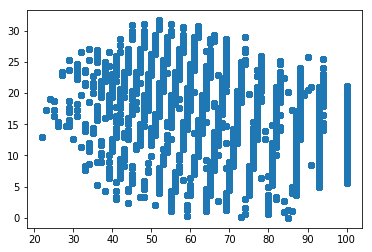

In [38]:
# Scatter plot
plt.plot(df_all['humidity'],df_all['temp_celsius'], 'o')
plt.show()

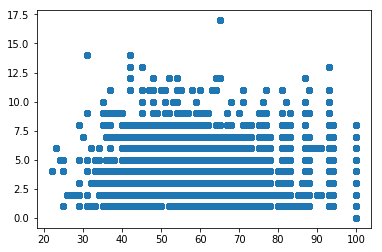

In [39]:
# Scatter plot
plt.plot(df_all['humidity'],df_all['wind_speed'], 'o')
plt.show()

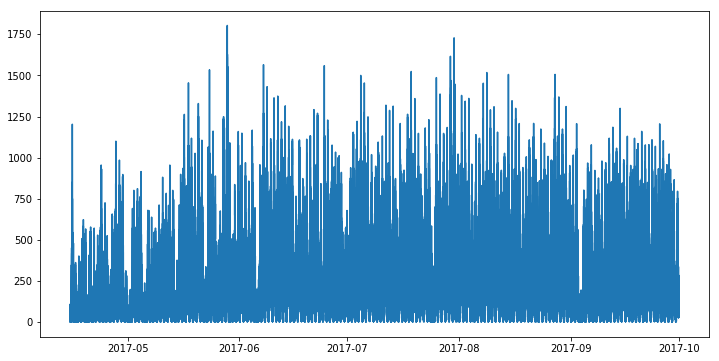

In [41]:
# Line chart
plt.figure(figsize=(12,6))
df_group = df_all.groupby(by='start_date')['duration_min'].sum()
plt.plot(df_group.index, df_group.values, '-')
plt.show()

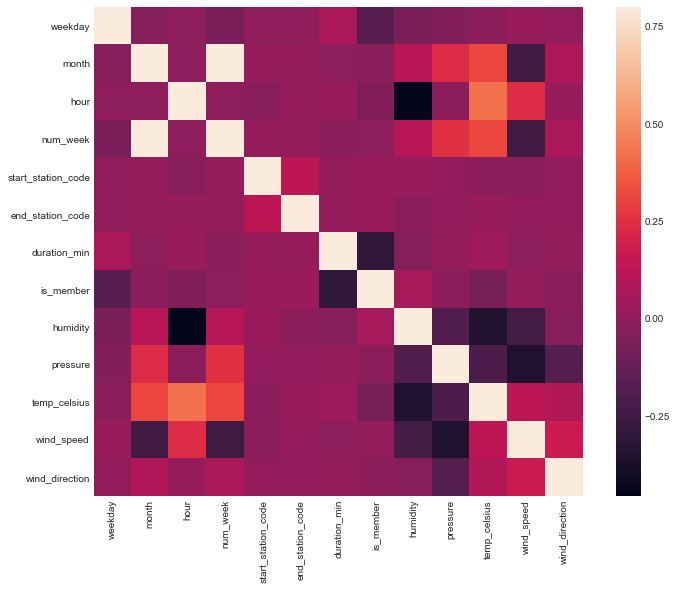

In [42]:
# the more advanced python visualization library
import seaborn as sns

# apply style to all the charts
sns.set_style('whitegrid')

# heatmap
corrmat = df_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()